# Classificação das imagens utilizando uma CNN

## Dataset

O dataset escolhido está disponível no [link](https://www.kaggle.com/datasets/ahmedabdellahismail/covid-19-chest-x-ray/data), o qual é composto de **1196** imagens, pertencentes a três classes:

*   Covid
*   Virus
*   Normal



Segue abaixo o código necessário para realizar download do dataset, realizar unzip e excluir arquivos desnecessários:

In [51]:
!kaggle datasets download -d ahmedabdellahismail/covid-19-chest-x-ray
!unzip /content/covid-19-chest-x-ray.zip
!rm /content/covid-19-chest-x-ray.zip

Dataset URL: https://www.kaggle.com/datasets/ahmedabdellahismail/covid-19-chest-x-ray
License(s): Apache 2.0
covid-19-chest-x-ray.zip: Skipping, found more recently modified local copy (use --force to force download)
unzip:  cannot find or open /content/covid-19-chest-x-ray.zip, /content/covid-19-chest-x-ray.zip.zip or /content/covid-19-chest-x-ray.zip.ZIP.
rm: cannot remove '/content/covid-19-chest-x-ray.zip': No such file or directory


## Imports

In [52]:
# !pip install torch
# !pip install torchinfo

In [53]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
from torchinfo import summary
%matplotlib inline

mySeed = 42
np.random.seed(mySeed)
torch.manual_seed(mySeed)
torch.cuda.manual_seed(mySeed)

In [54]:
# selecionar a GPU caso exista
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Pré-processamento dos dados

In [55]:
# Define a transformação que será aplicada nas imagens
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Redimensiona as imagens para 224x224 pixels
    transforms.ToTensor()
])

# Realiza o espelhamento horizontal das imagens para gerar mais dados
transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0), # Espelha as imagens horizontalmente
    transforms.Resize((224, 224)), # Redimensiona as imagens para 224x224 pixels
    transforms.ToTensor()
])

# Carrega o dataset da pasta, assumindo que as subpastas são as classes
originalDataset = datasets.ImageFolder(root="Data/", transform=transform)
flippedDataset = datasets.ImageFolder(root="Data/", transform=transform2)

# Concatena os datasets originais e espelhados
dataset = ConcatDataset([originalDataset, flippedDataset])

class_names = originalDataset.classes # [covid, normal, virus]

# Defina a proporção de dados de treinamento e teste
train_ratio = 0.7
validation_ratio = 0.15

# Calcula os tamanhos dos conjuntos de treino e teste
train_size = int(train_ratio * len(dataset))
validation_size = int(validation_ratio * len(dataset))
test_size = len(dataset) - train_size - validation_size

# Divide o dataset em conjuntos de treino e teste
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

# Cria os data loaders para carregar os dados em mini-lotes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, pin_memory=True)

In [56]:
# Conta a quantidade de imagens por classe no conjunto de treinamento
train_class_count = {}

for _, label in train_dataset:
    if label in train_class_count:
        train_class_count[label] += 1
    else:
        train_class_count[label] = 1

# Conta a quantidade de imagens por classe no conjunto de validacao
validation_class_count = {}

for _, label in validation_dataset:
    if label in validation_class_count:
        validation_class_count[label] += 1
    else:
        validation_class_count[label] = 1

# Conta a quantidade de imagens por classe no conjunto de teste
test_class_count = {}
for _, label in test_dataset:
    if label in test_class_count:
        test_class_count[label] += 1
    else:
        test_class_count[label] = 1

# Mostra a quantidade de imagens por classe nos conjuntos de treinamento
print(f'Tamanho do conjunto de treino: {len(train_loader.dataset)}')
print("Quantidade de imagens por classe no conjunto de treinamento:")
for class_idx, count in train_class_count.items():
    print(f"Classe {class_idx}: {count} imagens")

# Mostra a quantidade de imagens por classe nos conjuntos de validação
print(f'\nTamanho do conjunto de validação: {len(validation_loader.dataset)}')
print("Quantidade de imagens por classe no conjunto de validação:")
for class_idx, count in validation_class_count.items():
    print(f"Classe {class_idx}: {count} imagens")

# Mostra a quantidade de imagens por classe nos conjuntos de teste
print(f'\nTamanho do conjunto de teste: {len(test_loader.dataset)}')
print("Quantidade de imagens por classe no conjunto de teste:")
for class_idx, count in test_class_count.items():
    print(f"Classe {class_idx}: {count} imagens")


Tamanho do conjunto de treino: 1674
Quantidade de imagens por classe no conjunto de treinamento:
Classe 2: 611 imagens
Classe 1: 647 imagens
Classe 0: 416 imagens

Tamanho do conjunto de validação: 358
Quantidade de imagens por classe no conjunto de validação:
Classe 2: 132 imagens
Classe 1: 136 imagens
Classe 0: 90 imagens

Tamanho do conjunto de teste: 360
Quantidade de imagens por classe no conjunto de teste:
Classe 2: 123 imagens
Classe 1: 153 imagens
Classe 0: 84 imagens


## Definindo nosso modelo

In [57]:
class MyCNN(nn.Module):
    def __init__(self, num_diseases):
        super().__init__()

        self.features = nn.Sequential(
            # Entrada: 3x224x224 (3 canais de cor)
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Saída: 8x112x112

            # Entrada: 8x112x112
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Saída: 16x56x56
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveMaxPool2d((1, 1)), # Global Max Pooling
            nn.Flatten(),
            nn.Linear(16, num_diseases)  # Mapeia diretamente para o número de doenças
        )

    def forward(self, xb):
        xb = self.features(xb)
        xb = self.classifier(xb)
        return xb
    

model = MyCNN(len(class_names)).to(device)

torch.manual_seed(42) # Define a seed para reprodução dos resultados
torch.cuda.manual_seed(42) # Define a seed para reprodução dos resultados

In [58]:
summary(model=model,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
MyCNN (MyCNN)                            [32, 3, 224, 224]    [32, 3]              --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 16, 56, 56]     --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 8, 224, 224]    224                  True
│    └─BatchNorm2d (1)                   [32, 8, 224, 224]    [32, 8, 224, 224]    16                   True
│    └─ReLU (2)                          [32, 8, 224, 224]    [32, 8, 224, 224]    --                   --
│    └─MaxPool2d (3)                     [32, 8, 224, 224]    [32, 8, 112, 112]    --                   --
│    └─Conv2d (4)                        [32, 8, 112, 112]    [32, 16, 112, 112]   1,168                True
│    └─BatchNorm2d (5)                   [32, 16, 112, 112]   [32, 16, 112, 112]   32                   True
│    └─ReLU (6)   

## Funções de treinamento e validação

In [59]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

# Passo de treino
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    model.train()

    train_loss, train_acc = 0, 0

    # Passa por cada mini-lote
    for batch, (X, y) in enumerate(dataloader):
        # Envia os dados para o dispositivo de hardware
        X, y = X.to(device), y.to(device)

        y_pred = model(X) # Etapa de forward

        # Calcula e acumula a loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Zera os gradientes
        optimizer.zero_grad()

        # Calcula os gradientes
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()

        # Calcula e acumula a acurácia
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Calcula a média da loss e acurácia
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def val_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    model.eval() # Coloca o modelo em modo de avaliação
    val_loss, val_acc = 0, 0

    with torch.inference_mode():
        # Passa por cada mini-lote
        for batch, (X, y) in enumerate(dataloader):
            # Envia os dados para o dispositivo de hardware
            X, y = X.to(device), y.to(device)

            # Etapa de forward
            y_pred = model(X)

            # Calcula e acumula a loss
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()

            # Calcula e acumula a acurácia
            val_pred_labels = y_pred.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

    # Calcula a média da loss e acurácia
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []
    }

    model.to(device)

    # Loop de treinamento
    for epoch in tqdm(range(epochs)):
        # Treina o modelo
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        
        # Avalia o modelo
        val_loss, val_acc = val_step(model=model,
                                    dataloader=val_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

        # Imprime as métricas
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"val_loss: {val_loss:.4f} | "
          f"val_acc: {val_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    return results

def predict(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:

    model.eval()

    all_preds = []
    all_targets = []

    with torch.inference_mode():
        # Passa por cada mini-lote
        for batch, (X, y) in enumerate(dataloader):
            # Envia os dados para o dispositivo de hardware
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            
            all_preds.append(y_pred)
            all_targets.append(y)

    # Concatena as predições e as classes
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    return all_preds, all_targets


## Treinamento do modelo

In [60]:
# Define o otimizador e a função de loss
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Treina o modelo
cnn_results = train(model=model,
                    train_dataloader=train_loader,
                    val_dataloader=validation_loader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=30,
                    device=device)

  3%|▎         | 1/30 [00:12<06:10, 12.78s/it]

Epoch: 1 | train_loss: 1.1578 | train_acc: 0.4993 | val_loss: 0.8439 | val_acc: 0.6102


  7%|▋         | 2/30 [00:25<05:58, 12.82s/it]

Epoch: 2 | train_loss: 0.6420 | train_acc: 0.7316 | val_loss: 0.5391 | val_acc: 0.7639


 10%|█         | 3/30 [00:38<05:46, 12.83s/it]

Epoch: 3 | train_loss: 0.5300 | train_acc: 0.7969 | val_loss: 0.4777 | val_acc: 0.8238


 13%|█▎        | 4/30 [00:51<05:34, 12.85s/it]

Epoch: 4 | train_loss: 0.4501 | train_acc: 0.8354 | val_loss: 0.4380 | val_acc: 0.8290


 17%|█▋        | 5/30 [01:04<05:23, 12.93s/it]

Epoch: 5 | train_loss: 0.4114 | train_acc: 0.8607 | val_loss: 0.4015 | val_acc: 0.8342


 20%|██        | 6/30 [01:17<05:10, 12.92s/it]

Epoch: 6 | train_loss: 0.3716 | train_acc: 0.8715 | val_loss: 0.3723 | val_acc: 0.8550


 23%|██▎       | 7/30 [01:30<04:56, 12.91s/it]

Epoch: 7 | train_loss: 0.3484 | train_acc: 0.8677 | val_loss: 0.3501 | val_acc: 0.8707


 27%|██▋       | 8/30 [01:43<04:43, 12.90s/it]

Epoch: 8 | train_loss: 0.3197 | train_acc: 0.8848 | val_loss: 0.4075 | val_acc: 0.8507


 30%|███       | 9/30 [01:56<04:33, 13.02s/it]

Epoch: 9 | train_loss: 0.3073 | train_acc: 0.8914 | val_loss: 0.3397 | val_acc: 0.8837


 33%|███▎      | 10/30 [02:09<04:19, 12.99s/it]

Epoch: 10 | train_loss: 0.2949 | train_acc: 0.9031 | val_loss: 0.3590 | val_acc: 0.8863


 37%|███▋      | 11/30 [02:21<04:05, 12.90s/it]

Epoch: 11 | train_loss: 0.2797 | train_acc: 0.8973 | val_loss: 0.3180 | val_acc: 0.8863


 40%|████      | 12/30 [02:34<03:51, 12.85s/it]

Epoch: 12 | train_loss: 0.2688 | train_acc: 0.9021 | val_loss: 0.4060 | val_acc: 0.8681


 43%|████▎     | 13/30 [02:47<03:39, 12.93s/it]

Epoch: 13 | train_loss: 0.2827 | train_acc: 0.8914 | val_loss: 0.3029 | val_acc: 0.8993


 47%|████▋     | 14/30 [03:01<03:29, 13.07s/it]

Epoch: 14 | train_loss: 0.2574 | train_acc: 0.9133 | val_loss: 0.3245 | val_acc: 0.8759


 50%|█████     | 15/30 [03:14<03:16, 13.13s/it]

Epoch: 15 | train_loss: 0.2487 | train_acc: 0.9156 | val_loss: 0.3041 | val_acc: 0.8967


 53%|█████▎    | 16/30 [03:27<03:04, 13.17s/it]

Epoch: 16 | train_loss: 0.2421 | train_acc: 0.9125 | val_loss: 0.3300 | val_acc: 0.8689


 57%|█████▋    | 17/30 [03:40<02:50, 13.09s/it]

Epoch: 17 | train_loss: 0.2492 | train_acc: 0.9078 | val_loss: 0.2920 | val_acc: 0.8863


 60%|██████    | 18/30 [03:53<02:36, 13.02s/it]

Epoch: 18 | train_loss: 0.2296 | train_acc: 0.9156 | val_loss: 0.2960 | val_acc: 0.8993


 63%|██████▎   | 19/30 [04:06<02:22, 12.92s/it]

Epoch: 19 | train_loss: 0.2140 | train_acc: 0.9246 | val_loss: 0.3283 | val_acc: 0.8759


 67%|██████▋   | 20/30 [04:19<02:08, 12.90s/it]

Epoch: 20 | train_loss: 0.2072 | train_acc: 0.9263 | val_loss: 0.3035 | val_acc: 0.8950


 70%|███████   | 21/30 [04:32<01:56, 12.93s/it]

Epoch: 21 | train_loss: 0.2092 | train_acc: 0.9184 | val_loss: 0.3113 | val_acc: 0.8924


 73%|███████▎  | 22/30 [04:44<01:42, 12.86s/it]

Epoch: 22 | train_loss: 0.1984 | train_acc: 0.9316 | val_loss: 0.2758 | val_acc: 0.8915


 77%|███████▋  | 23/30 [04:57<01:29, 12.82s/it]

Epoch: 23 | train_loss: 0.1849 | train_acc: 0.9422 | val_loss: 0.2742 | val_acc: 0.8950


 80%|████████  | 24/30 [05:10<01:17, 12.91s/it]

Epoch: 24 | train_loss: 0.1852 | train_acc: 0.9422 | val_loss: 0.2918 | val_acc: 0.8967


 83%|████████▎ | 25/30 [05:23<01:04, 12.85s/it]

Epoch: 25 | train_loss: 0.1931 | train_acc: 0.9369 | val_loss: 0.2772 | val_acc: 0.8889


 87%|████████▋ | 26/30 [05:36<00:51, 12.91s/it]

Epoch: 26 | train_loss: 0.1857 | train_acc: 0.9375 | val_loss: 0.2929 | val_acc: 0.9019


 90%|█████████ | 27/30 [05:49<00:38, 12.91s/it]

Epoch: 27 | train_loss: 0.1810 | train_acc: 0.9377 | val_loss: 0.2622 | val_acc: 0.8941


 93%|█████████▎| 28/30 [06:02<00:25, 12.90s/it]

Epoch: 28 | train_loss: 0.1728 | train_acc: 0.9434 | val_loss: 0.2714 | val_acc: 0.9106


 97%|█████████▋| 29/30 [06:15<00:12, 12.92s/it]

Epoch: 29 | train_loss: 0.1639 | train_acc: 0.9474 | val_loss: 0.2559 | val_acc: 0.9019


100%|██████████| 30/30 [06:27<00:00, 12.93s/it]

Epoch: 30 | train_loss: 0.1760 | train_acc: 0.9386 | val_loss: 0.2799 | val_acc: 0.8863


## Teste e Resultados

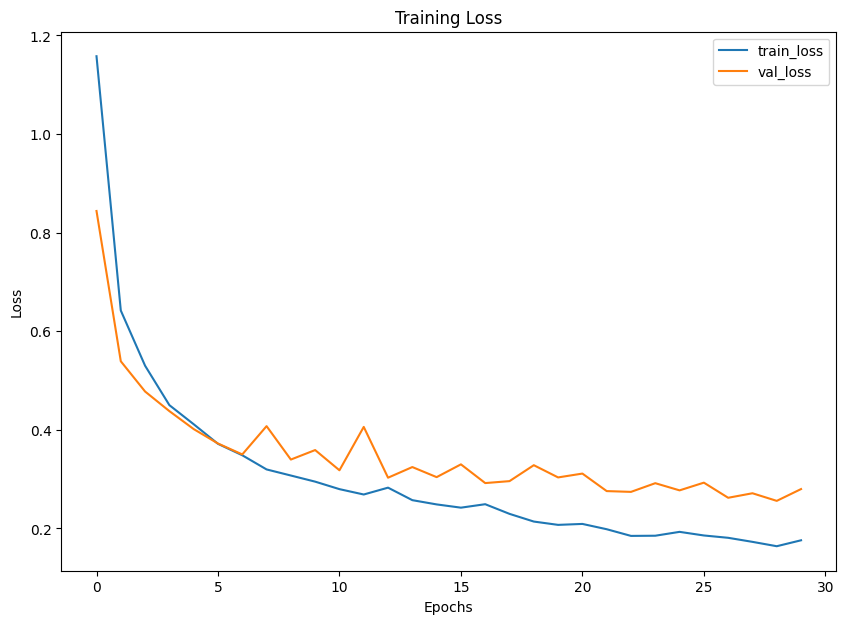

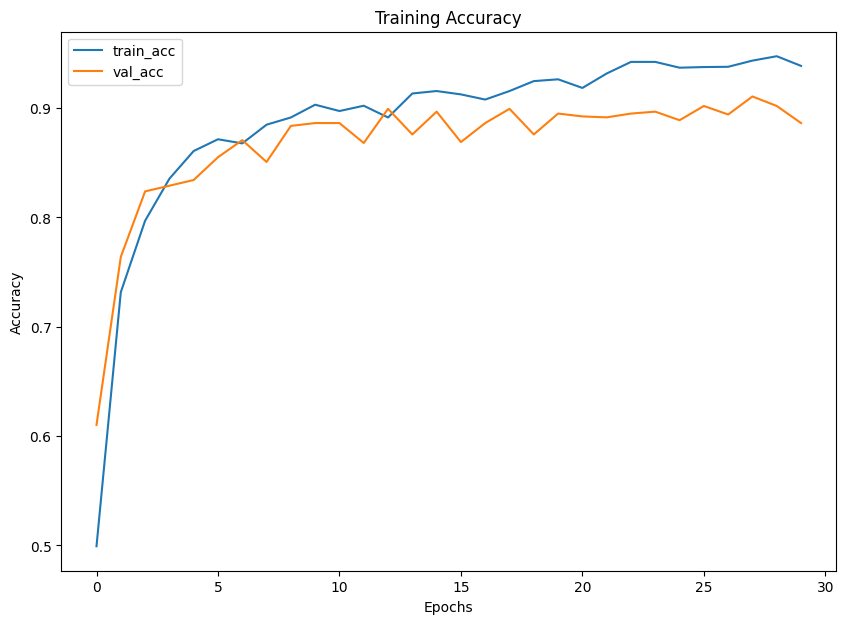

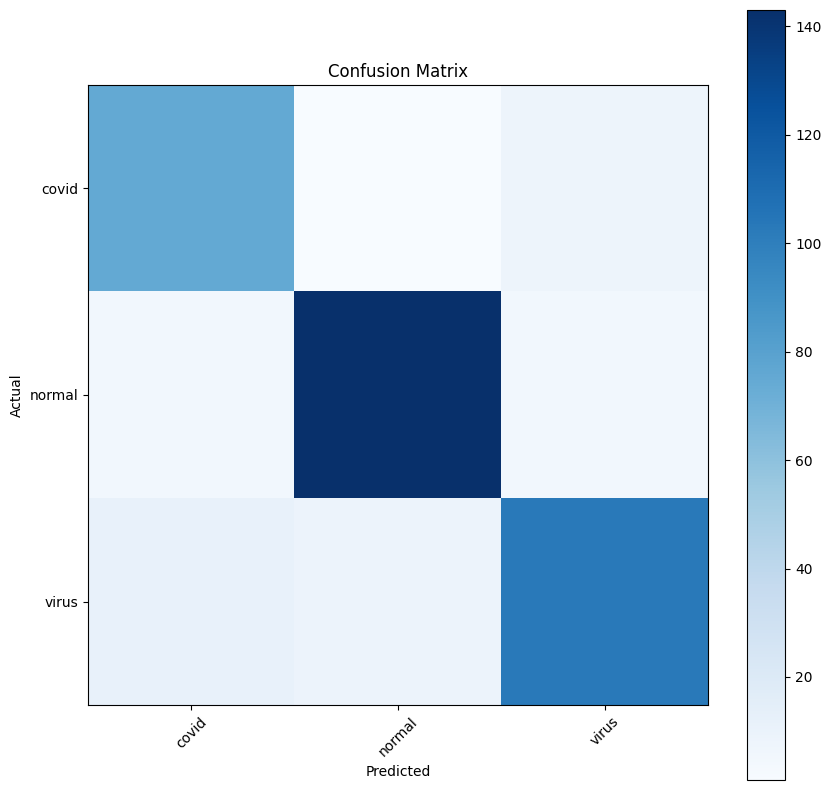

              precision    recall  f1-score   support

       covid       0.82      0.89      0.86        84
      normal       0.93      0.93      0.93       153
       virus       0.89      0.84      0.86       123

    accuracy                           0.89       360
   macro avg       0.88      0.89      0.88       360
weighted avg       0.89      0.89      0.89       360



In [61]:
## Avaliação do modelo

# Plota as métricas de treinamento
plt.figure(figsize=(10, 7))
plt.plot(cnn_results["train_loss"], label="train_loss")
plt.plot(cnn_results["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(cnn_results["train_acc"], label="train_acc")
plt.plot(cnn_results["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Realiza a predição no conjunto de teste
all_preds, all_targets = predict(model=model,
                                 dataloader=test_loader,
                                 device=device)

# Calcula a matriz de confusão
conf_matrix = confusion_matrix(all_targets.cpu(), all_preds.argmax(dim=1).cpu())

# Plota a matriz de confusão
plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xticks(np.arange(3), class_names, rotation=45)
plt.yticks(np.arange(3), class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Imprime o classification report
print(classification_report(all_targets.cpu(), all_preds.argmax(dim=1).cpu(), target_names=class_names))
